In [1]:
from datetime import datetime
import requests
from io import StringIO
import json

import pandas as pd
import geopandas as gpd
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.set_option('display.max_columns', 50)

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [2]:
# csv = pd.read_csv('../data/Metro_Nashville_Police_Department_Incidents.csv')
# csv['Incident Reported'] = pd.to_datetime(csv['Incident Reported'], errors = 'coerce')
# csv = csv.set_index('Incident Reported')
# sum(csv.loc['2021-01-01':'2021-06-30']['Offense Description'] == 'BURGLARY- AGGRAVATED')

In [3]:
soda_endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.geojson'
soda_params = {
    '$where': 'incident_reported between \'2021-01-01\' and \'2021-06-30\'',
    'offense_description': 'BURGLARY- AGGRAVATED',
    '$limit': 10000
}
soda_response = requests.get(soda_endpoint, params = soda_params)

In [4]:
incidents = gpd.read_file(StringIO(soda_response.text))
# incidents.head()

2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [5]:
census_tracts = gpd.read_file('../data/tl_2019_47_tract/tl_2019_47_tract.shp')
# census_tracts.head()
# census_tracts.crs

In [6]:
davidson_county = census_tracts[census_tracts['COUNTYFP'] == '037'][['TRACTCE', 'geometry']]
davidson_county = davidson_county.rename(columns = {'TRACTCE': 'tract'})
davidson_county = davidson_county.to_crs('EPSG:4326')

In [7]:
incidents_by_tract = gpd.sjoin(incidents, davidson_county, op = 'within')

In [8]:
display(incidents_by_tract.groupby('tract')['incident_number'].nunique().nlargest(5))

tract
016300    53
016200    21
011001    20
019300    19
019500    19
Name: incident_number, dtype: int64

3. For this part, you'll need to request a [census API key](https://api.census.gov/data/key_signup.html). Using the [2019 American Community Survey API](https://www.census.gov/data/developers/data-sets/acs-5year.html), obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [9]:
with open('../data/census.json') as file:
    credentials = json.load(file)

api_key = credentials['api_key']

In [10]:
detailed_endpoint = 'https://api.census.gov/data/2019/acs/acs5'
detailed_params = {
    'get': 'B01001_001E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}
detailed_response = requests.get(detailed_endpoint, params = detailed_params)

In [11]:
population = detailed_response.json()
population = pd.DataFrame(data = population[1:], columns = population[0])
population = population.rename(columns={'B01001_001E': 'population'})
population['population'] = population['population'].astype(int)

In [12]:
subject_endpoint = 'https://api.census.gov/data/2019/acs/acs5/subject'
subject_params = {
    'get': 'S1901_C01_012E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}
subject_response = requests.get(subject_endpoint, params = subject_params)

In [13]:
median_income = subject_response.json()
median_income = pd.DataFrame(data = median_income[1:], columns = median_income[0])
median_income = median_income.rename(columns={'S1901_C01_012E': 'median_income'})
median_income['median_income'] = median_income['median_income'].astype(int)
median_income['median_income'] = median_income['median_income'].replace(-666666666, np.nan)

In [14]:
dfs = [incidents_by_tract, population, median_income]
incidents_population_income = reduce(lambda left, right: pd.merge(left, right), dfs)
# incidents_population_income.head()

4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [15]:
chloropleth = pd.DataFrame(incidents_population_income.groupby(['tract', 'population', 'median_income'],
                                                               as_index = False)['incident_number'].nunique())
chloropleth['incident_rate'] = chloropleth['incident_number'] / chloropleth['population'] * 1000
chloropleth = pd.merge(left = davidson_county, right = chloropleth, how = 'left')

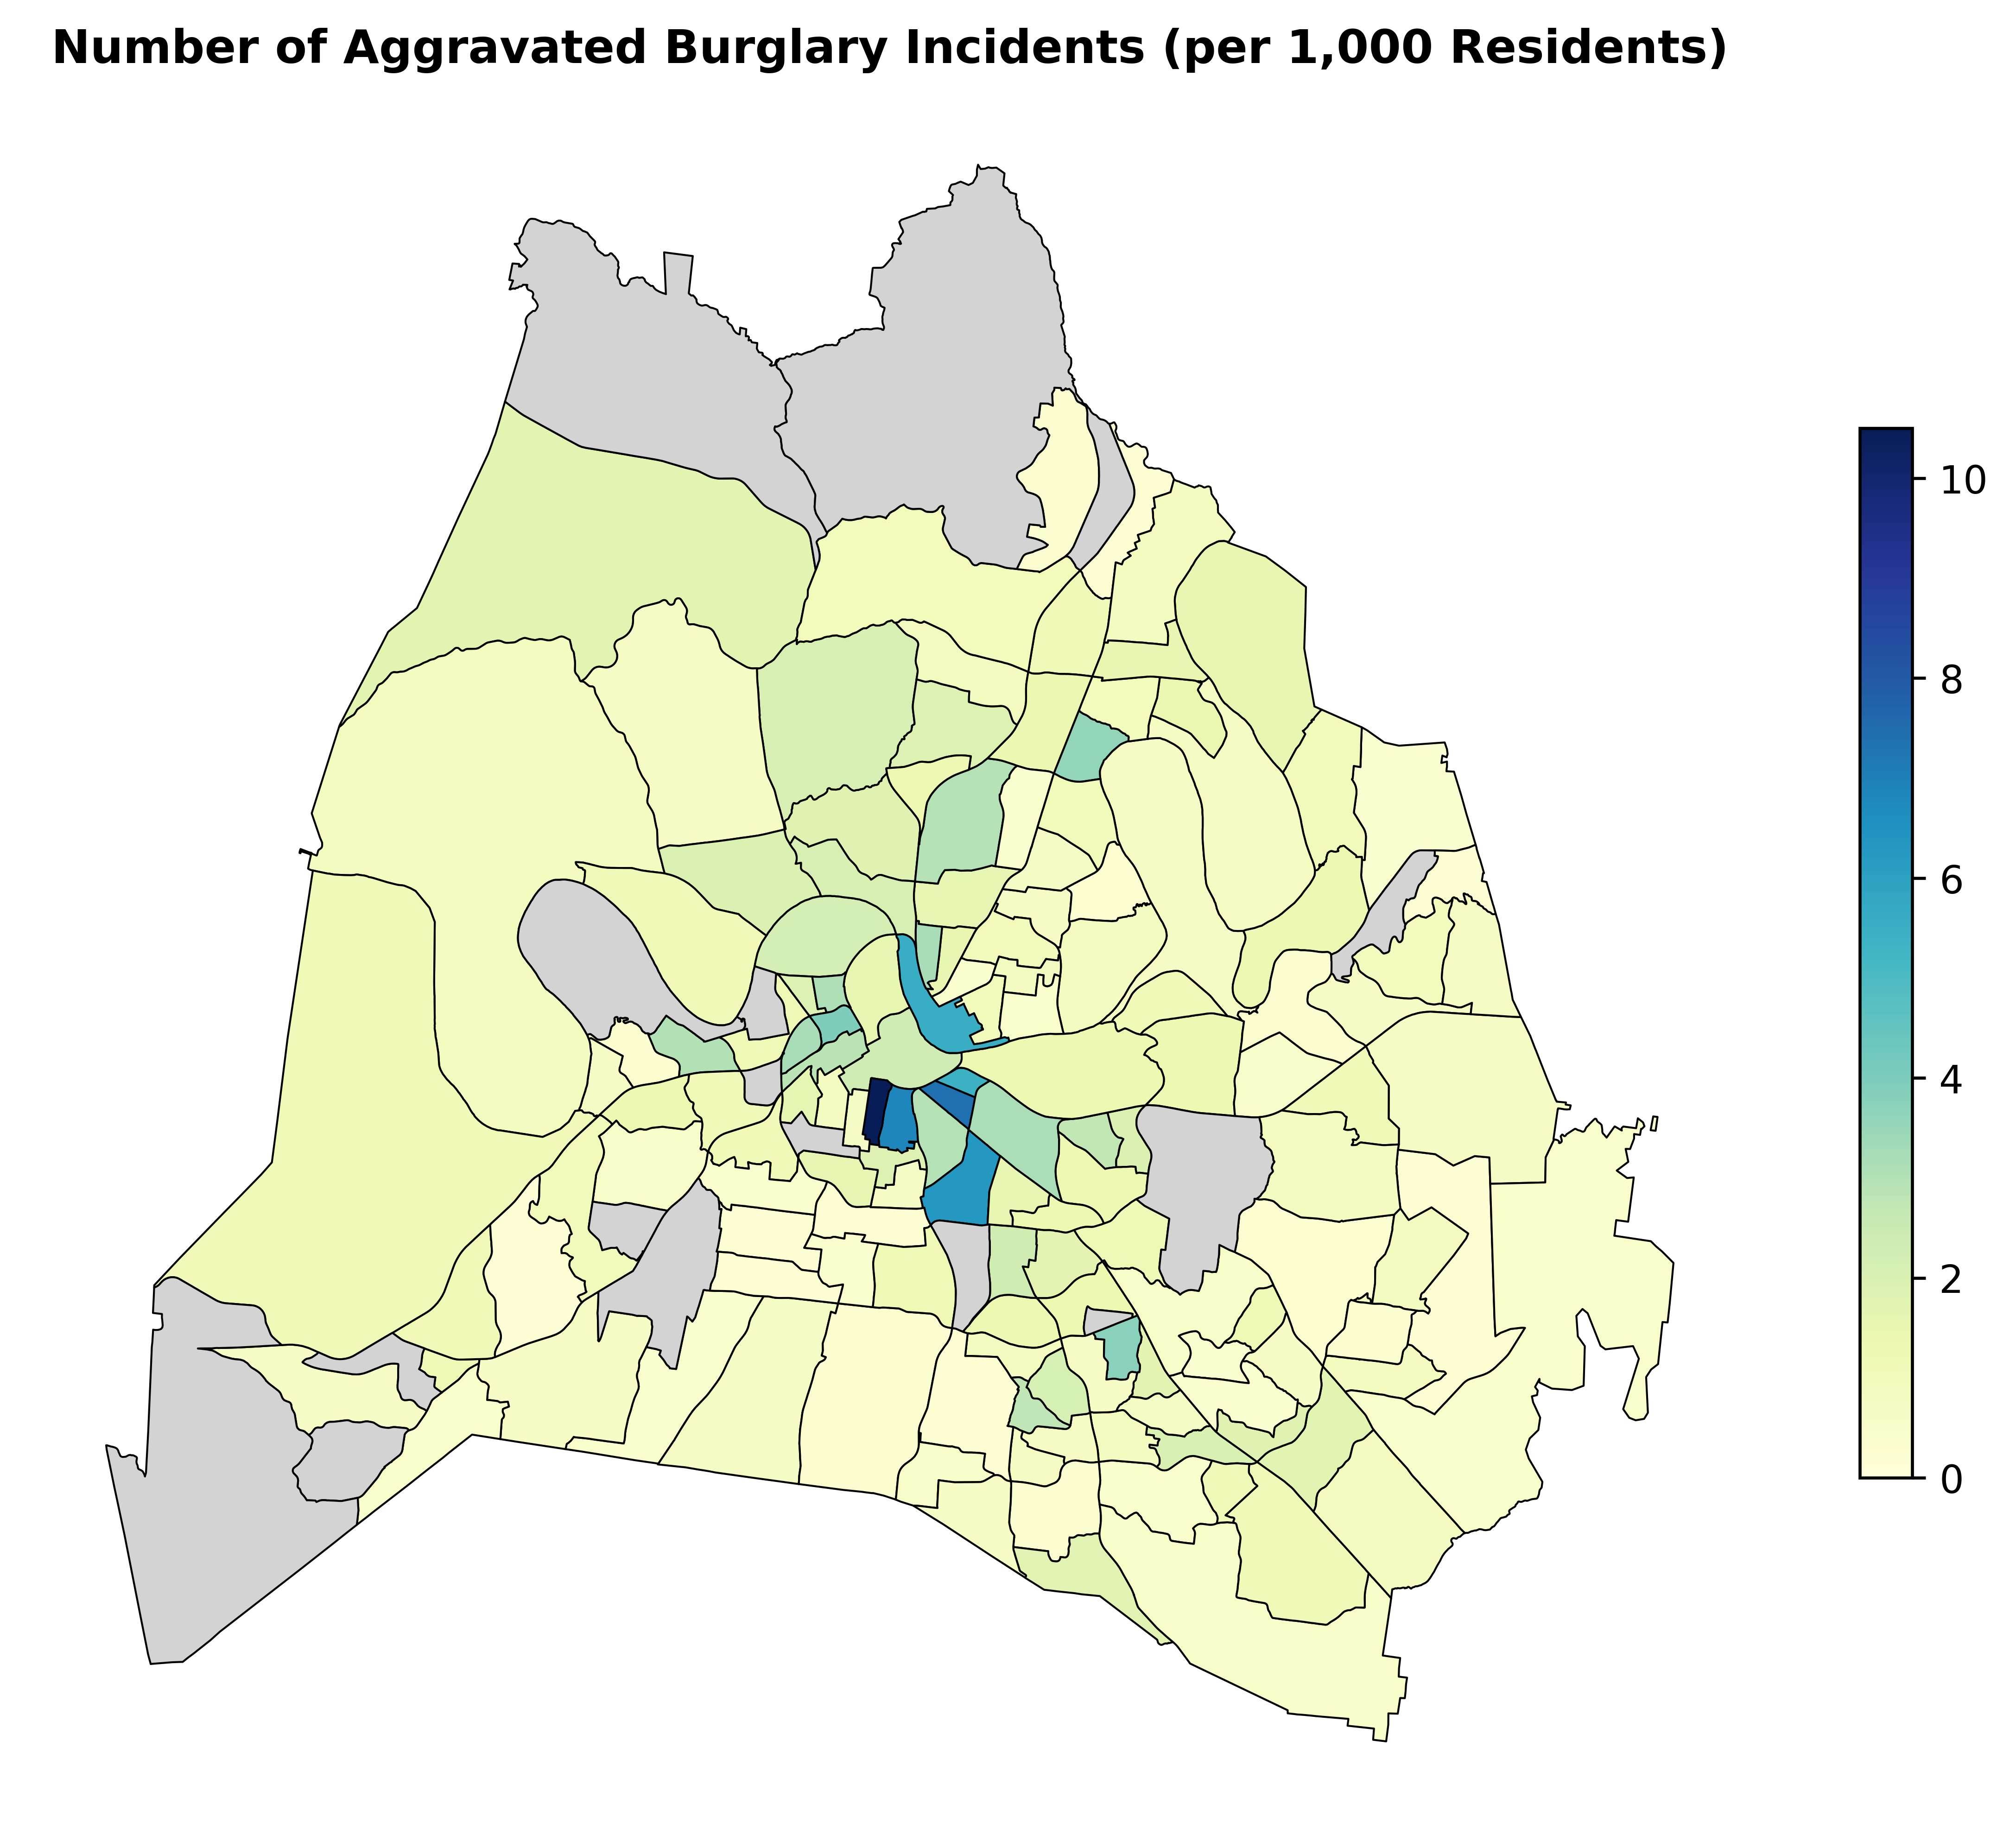

In [16]:
fig, ax = plt.subplots(figsize = (10, 10), dpi = 600)
plt.title('Number of Aggravated Burglary Incidents (per 1,000 Residents)', fontsize = 12, fontweight = 'bold')
ax.axis('off')

chloropleth.plot(column = 'incident_rate', 
                 cmap = 'YlGnBu',
                 missing_kwds = {'color': 'lightgrey'},
                 edgecolor = 'black', 
                 linewidth = 0.5,
                 vmin = 0, 
                 vmax = 10.5,
                 ax = ax,
                 legend = True,
                 legend_kwds = {'shrink': 0.5});

5. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the [Generalized Linear Models](https://www.statsmodels.org/stable/glm.html) module of the statsmodels library.

    a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

    b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).

    c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out [this tutorial](https://timeseriesreasoning.com/contents/negative-binomial-regression-model/).

    d. How do your models compare? Hint: the fit models have an AIC attribute.

6. Prepare a short presentation (<10 minutes) of your findings.

Additional Resources for Generalized Linear Models:
* DataCamp - [Generalized Linear Models in Python](https://learn.datacamp.com/courses/generalized-linear-models-in-python)
* [Beyond Multiple Linear Regression, Chapter 4](https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html) Warning - the code in this book is all R, but the conceptual explanations are very clear.
* [This set of notes](https://apwheele.github.io/MathPosts/PoissonReg.html#negative-binomial-when-the-poisson-does-not-fit), which talks about the problem of overdispersion.